In [ ]:
!nvidia-smi

Mon May 24 21:36:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
try:
    import google.colab
    IN_COLAB = True
    
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/My Drive/tweets-3-classes-9999.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,raw_text,label
0,@JanaBanana5 Oh my word...so tell me are you a...,negative
1,Just watched the series finale of Scrubs. Why ...,negative
2,Just screwed up the fried noodles by adding ra...,negative
3,@ladybug8320 5 weeks is a long time!,negative
4,Synching my contacts from my old mobile to iPh...,negative


In [ ]:
df.label.unique()

array(['negative', 'positive', 'neutral'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df.label)
print(le.classes_)

df['classes'] = le.transform(df.label)

['negative' 'neutral' 'positive']


In [ ]:
import matplotlib.pyplot as plt


(array([3333.,    0.,    0.,    0.,    0., 3333.,    0.,    0.,    0.,
        3333.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

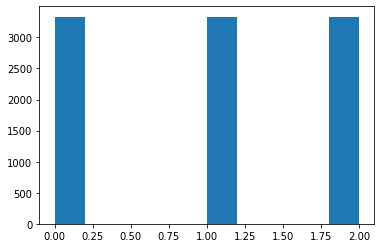

In [ ]:
plt.hist(df.classes)

In [ ]:
df.label.value_counts()

negative    3333
positive    3333
neutral     3333
Name: label, dtype: int64

In [ ]:
df.isna().value_counts()

raw_text  label  classes
False     False  False      9999
dtype: int64

(array([3333.,    0.,    0.,    0.,    0., 3333.,    0.,    0.,    0.,
        3333.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

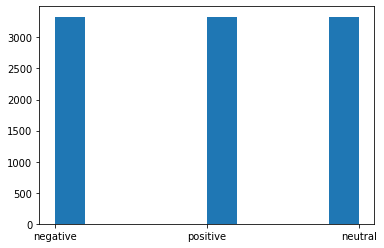

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df.label)

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.3MB 67kB/s 


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.raw_text, df.classes, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=2000,
        task_type='GPU',
        # iterations=30000,
        depth=5, 
        eval_metric= 'Accuracy',
        # od_type='Iter',
        # od_wait=500,
        **kwargs
    )
    return model.fit(
            train_pool,
            eval_set=test_pool,
            verbose=100,
            plot=True,
            use_best_model=True)

In [ ]:
train_pool = Pool(
    data=pd.DataFrame(X_train),
    label=y_train,
    text_features=['raw_text']
)
valid_pool = Pool(
    data=pd.DataFrame(X_test), 
    label=y_test,
    text_features=['raw_text']
)

In [ ]:
model = fit_model(
    train_pool, valid_pool,
    learning_rate=0.35,
    tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak', 'Punctuation', 'Unknown'],
            'sub_tokens_policy':'SingleToken',
            'languages': ['english'],
            'skip_empty': 'True',
            # 'lemmatizing' : 'True'
            # 'number_process_policy': 'Replace'
            # 'lemmatizing': 'true'
        }
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '100000',
            'occurence_lower_bound': 40,
            # 'gram_order': 3
            # 'gram_order': 2
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5637948	test: 0.5486667	best: 0.5486667 (0)	total: 9.69ms	remaining: 19.4s
100:	learn: 0.7638234	test: 0.7133333	best: 0.7156667 (95)	total: 681ms	remaining: 12.8s
200:	learn: 0.7938277	test: 0.7236667	best: 0.7266667 (172)	total: 1.36s	remaining: 12.2s
300:	learn: 0.8112588	test: 0.7313333	best: 0.7360000 (263)	total: 2.01s	remaining: 11.4s
400:	learn: 0.8278325	test: 0.7373333	best: 0.7376667 (393)	total: 2.69s	remaining: 10.7s
500:	learn: 0.8448350	test: 0.7433333	best: 0.7453333 (496)	total: 3.37s	remaining: 10.1s
600:	learn: 0.8544078	test: 0.7450000	best: 0.7473333 (511)	total: 4.01s	remaining: 9.34s
700:	learn: 0.8666952	test: 0.7440000	best: 0.7473333 (511)	total: 4.75s	remaining: 8.81s
800:	learn: 0.8774111	test: 0.7453333	best: 0.7473333 (511)	total: 5.45s	remaining: 8.16s
900:	learn: 0.8862695	test: 0.7483333	best: 0.7490000 (830)	total: 6.06s	remaining: 7.4s
1000:	learn: 0.8945564	test: 0.7506667	best: 0.7520000 (998)	total: 6.77s	remaining: 6.76s
1100:	learn: 0